In [1]:
# Imports
import torch
from torch import nn # neural network components
import matplotlib.pyplot as plt # visualisation
import numpy as np

In [2]:
# Device agnostic
# use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device '{device}'")

Using device 'cpu'


In [3]:
# known data from linear regression formula
weight = 0.7
bias = 0.3

start = 0
end = 5 # larger data set
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # why unsqueeze? to make it a column?
y = weight * X + bias
print(f"y size {y.size()}")

y size torch.Size([250, 1])


In [4]:
# Split data into Training and Test sets 80/20 split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(200, 200, 50, 50)

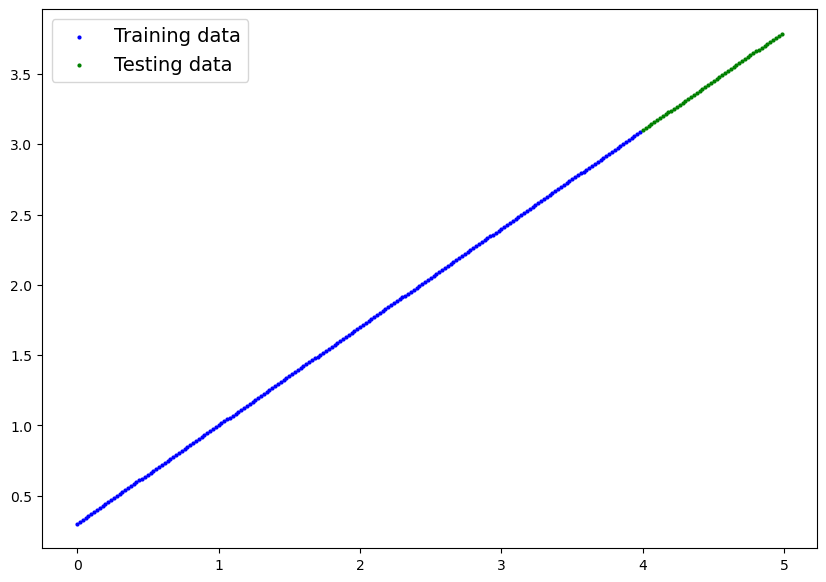

In [5]:
# Visualise
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10,7))
    
    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        # plot predictions
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    # Show legend
    plt.legend(prop={"size": 14})

plot_predictions()

In [6]:
from torch import nn

# Build model - Simple Linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # random weight parameter
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        # random bias parameter
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # linear regression formula                      
                                        

In [7]:
# Create instance of model with random initial state

# torch.manual_seed(42) # manual_seed makes random numbers deterministic

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([-0.3383], requires_grad=True),
 Parameter containing:
 tensor([0.8537], requires_grad=True)]

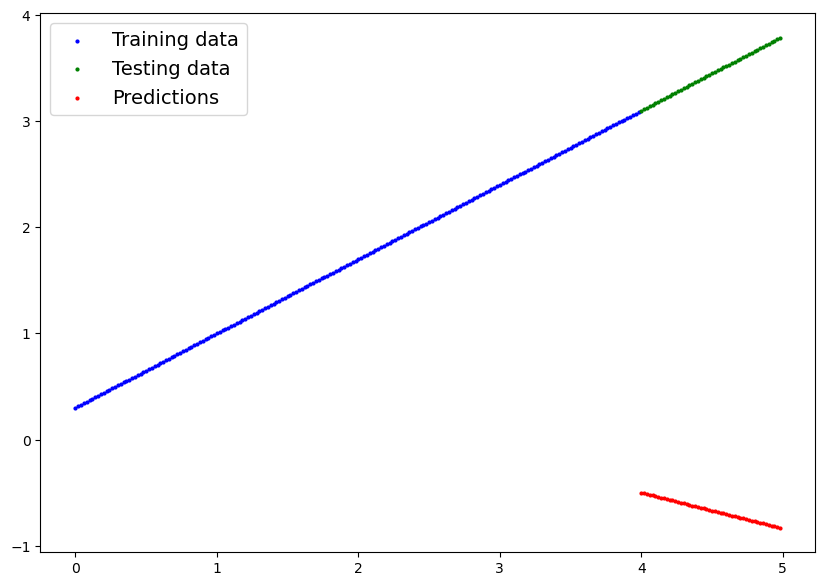

In [8]:
# Run prediction with untrained model
with torch.inference_mode():
    y_preds = model_0(X_test)

# display prediction
plot_predictions(predictions=y_preds)

In [9]:
# set up loss function
loss_fn = nn.L1Loss()

# set up optimiser - stochastic gradient descent - starts randomly then adjusts gradually
optimiser_fn = torch.optim.SGD(params=model_0.parameters(),
                               lr = 0.001) # lr = learning rate, most important hyperparameter

In [10]:
# Training loop and testing loop

epochs = 2000 # hyperparameter - we set it ourselves

# track values during training
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    epoch_count.append(epoch)
    model_0.train() # train mode in pytorch set
    
    # forward pass
    y_pred = model_0(X_train)
    
    # calculate loss (input, target)
    loss = loss_fn(y_pred, y_train)
    loss_values.append(loss)
    
    # optimiser zero grad
    optimiser_fn.zero_grad()
    
    # perform back propogation
    loss.backward()
    
    # step the optimizer
    optimiser_fn.step()
    
    # Testing against the test data
    model_0.eval()
    # inference mode turns off gradient tracking
    with torch.inference_mode():

        # forward pass
        test_pred = model_0(X_test)

        # calculate the loss value
        test_loss = loss_fn(test_pred, y_test)
        
        test_loss_values.append(test_loss)

    if epoch % 5000 == 0:    
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        

Epoch: 0 | Test: 1.589064121246338 | Test loss: 4.098753929138184


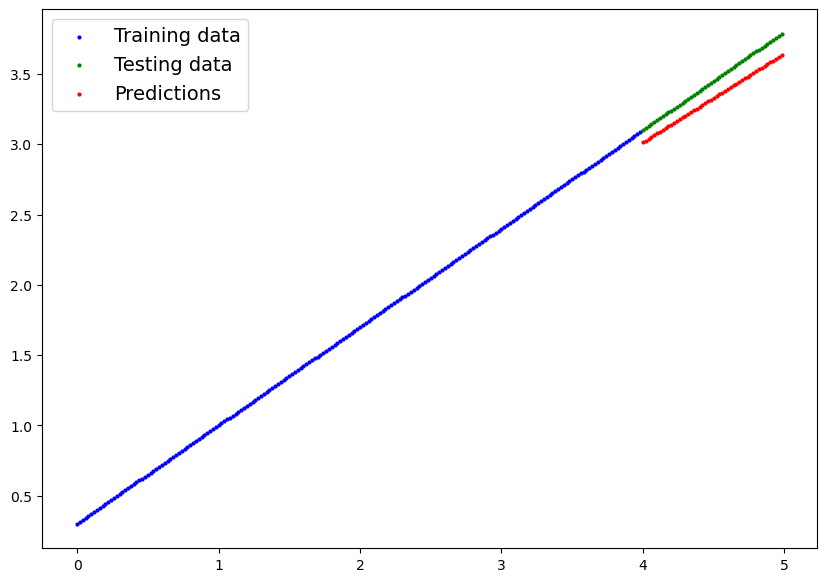

In [11]:
# Run predictions using trained model
model_0.eval()
# inference mode turns off gradient tracking, Performance improvements
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

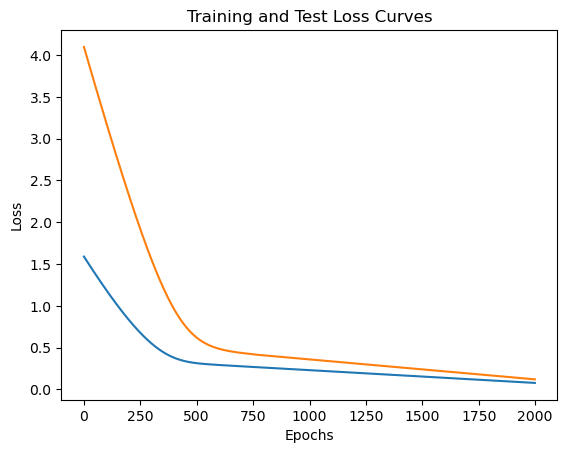

In [12]:
# Plot the outputs of the loss function
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.show()